#### 利用online_shoppers_intention進行消費者是否有購買的預測####

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import seaborn as sns

In [2]:
original_data=pd.read_csv("online_shoppers_intention.csv")
original_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


##### 丟掉所有類別項目的屬性，只留下數值型態的屬性，好讓我們進行簡單的分析

In [3]:
data=original_data.drop(['Month','VisitorType','Weekend'],1)
train, test = train_test_split(data, test_size=0.2)
x_train=train.drop('Revenue',1)
x_test=test.drop('Revenue',1)
y_train=train['Revenue']*1##超快的方法把TF轉10
y_test=test['Revenue']*1##超快的方法把TF轉10

標準化變數值

In [4]:
from sklearn.preprocessing import StandardScaler 
sc=StandardScaler()
sc.fit(x_train)
x_train_nor=sc.transform(x_train)
x_test_nor=sc.transform(x_test) 

C:\ana\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ana\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\ana\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


利用簡單線性回歸來進行預測

In [5]:
from sklearn.linear_model import LinearRegression
#建立模型
model=LinearRegression()
model.fit(x_train_nor,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [6]:
print('模型得分為',round(model.score(x_test_nor,y_test),4))

模型得分為 0.2658


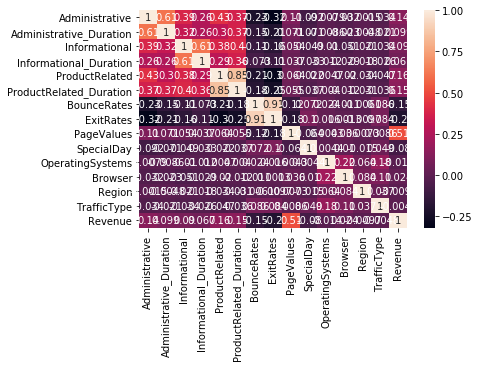

In [7]:
data=original_data.drop(['Month','VisitorType','Weekend'],1)
data.head()
train, test = train_test_split(data, test_size=0.2)
corr=train.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,annot=True)

#### 我們可以看出若是資料用最基本的方式選取數值型態做正規化後去預測使用者是否會進行購買，準確率只有26%左右###
我們想辦法基於這樣的標準看能不能透過一些方法，將準確率提高。
原先模型具有下列的問題:

    1.有其他類別型態的變數並無考慮進去，可能會有underfitting的情形
    
    2.像是OperatingSystems,Browser,Region,TrafficType這些變數雖然是數值型態，不過實際上是類別，若是按造原先的預設數值去進行回歸分析
      則會有解釋上的問題EX:假設windows代表1 ios代表2 無法說明為什麼ios的值意義上是windows的兩倍，其他的類別尺度也是有這樣的錯誤
      
    3.共線性問題，若兩個變數擁有高度相關，那麼在做線性回歸時就會造成係數差異會很大，導致結果不準確。
    
    4.線性回歸主要是用來針對連續值做處理，而我們的預測資料是離散的因此在迴歸分析上準確率會很差

#### 改進方法####

    1.將類別屬性的資料一併考慮進去

    2.將類別尺度的變數轉成dummy variable才不會有解釋上的問題

    3.將高度相關的變數進行剃除 EX:ExitRates與BounceRates只保留一個

    4.改使用對於分類具有較高準確度的模型EX:logstic or SVM


1.將類別屬性的資料一併考慮進去

In [8]:
pd.set_option('display.max_columns', 500)
data=original_data

2.將類別尺度的變數轉成dummy variable才不會有解釋上的問題

In [9]:
data=original_data
data = pd.concat([data,pd.get_dummies(data['Month'],prefix="M")], axis=1, join_axes=[data.index])
data = pd.concat([data,pd.get_dummies(data['OperatingSystems'],prefix="O")], axis=1, join_axes=[data.index])
data = pd.concat([data,pd.get_dummies(data['VisitorType'],prefix="V")], axis=1, join_axes=[data.index])
data = pd.concat([data,pd.get_dummies(data['Weekend'],prefix="W")], axis=1, join_axes=[data.index])
##data = pd.concat([data,pd.get_dummies(data['TrafficType'],prefix="T")], axis=1, join_axes=[data.index])
##由於traffic type對於結果影響不顯著，以及類別項目太多，因此選擇drop掉這個變數以避免overfitting


3.將高度相關的變數進行剃除 EX:ExitRates與BounceRates只保留一個

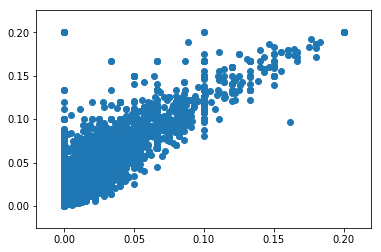

In [10]:
plt.scatter(data['BounceRates'], data['ExitRates'])
##兩者相關係數高，只保留一個即可

In [11]:
##由於traffic type對於結果影響不顯著，以及類別項目太多，因此選擇drop掉這個變數以避免overfitting
data=data.drop(['Month','OperatingSystems','VisitorType','Weekend','TrafficType','ExitRates'],1)
data.head()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,PageValues,SpecialDay,Browser,Region,Revenue,M_Aug,M_Dec,M_Feb,M_Jul,M_June,M_Mar,M_May,M_Nov,M_Oct,M_Sep,O_1,O_2,O_3,O_4,O_5,O_6,O_7,O_8,V_New_Visitor,V_Other,V_Returning_Visitor,W_False,W_True
0,0,0.0,0,0.0,1,0.000000,0.20,0.0,0.0,1,1,False,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.0,0.0,2,1,False,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.0,0.0,1,9,False,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.0,0.0,2,2,False,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.0,0.0,3,1,False,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1


In [12]:
train, test = train_test_split(data, test_size=0.2)
x_train=train.drop('Revenue',1)
y_train=train['Revenue']
x_test=test.drop('Revenue',1)
y_test=test['Revenue']

In [13]:
sc=StandardScaler()
sc.fit(x_train)
x_train_nor=sc.transform(x_train)
x_test_nor=sc.transform(x_test) 

C:\ana\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ana\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ana\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


4.改使用對於分類具有較高準確度的模型EX:logstic or SVM

In [14]:
from sklearn.linear_model  import LogisticRegression
lr=LogisticRegression()
lr.fit(x_train_nor,y_train)

C:\ana\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [15]:
from sklearn.metrics import confusion_matrix
cnf=confusion_matrix(y_test,lr.predict(x_test_nor))
print('混淆矩陣: ',cnf)

混淆矩陣:  [[2031   50]
 [ 232  153]]


In [16]:
#plot confusion matrix 官網提供

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
import itertools
target_name=['no','yes'] #是否漲股

Confusion matrix, without normalization
[[2031   50]
 [ 232  153]]


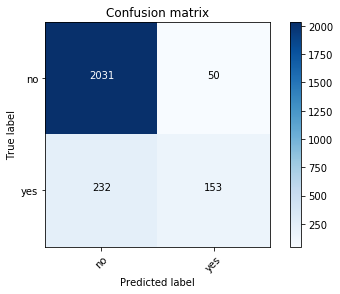

In [18]:
plot_confusion_matrix(cnf,target_name)

In [19]:

Accuracy=(cnf[0,0]+cnf[1,1])/(cnf[0,0]+cnf[1,0]+cnf[0,1]+cnf[1,1])
Accuracy

0.8856447688564477

In [20]:
from sklearn.preprocessing import StandardScaler 
sc=StandardScaler()
sc.fit(x_train)
x_train_nor=sc.transform(x_train)
x_test_nor=sc.transform(x_test) 
#x_train_nor

C:\ana\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ana\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\ana\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


In [21]:

from sklearn.metrics import accuracy_score

# Custom kernel function
#def my_kernel(X, Y):
    #return np.dot(X, Y.T)
  
penalty = 0.05

svm = SVC(C=penalty, kernel="linear", probability=True)
svm.fit(x_train_nor, y_train)
acc_rate = accuracy_score(y_test, svm.predict(x_test_nor)) * 100
print("Penalty = %.2f, Accuracy = %.6f %%" % (penalty, acc_rate))

Penalty = 0.05, Accuracy = 89.132198 %


###準確率大幅提升已經接近90%###